In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import torch.nn.init as init

from modules.utils import FeedForwardNetwork, create_gif, clear_temp
from modules.problems import Diffusion
from modules.training import train

import scienceplots
plt.style.use(['science'])
mpl.rcParams["font.size"] = "12"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
def set_boundary_values(problem, x_sampled, t_left_sampled, t_right_sampled):
    
    def nearest_index(array, values):
            values = [np.abs(array - v).argmin().item() for v in values.detach().numpy()]
            return values
    
    t = torch.linspace(0, problem.T, problem.Nt)
    x = torch.linspace(problem.L, problem.R, problem.Nx)
    problem.left_values =  problem.left_boundary [nearest_index(t, t_left_sampled) ].to(device)
    problem.right_values = problem.right_boundary[nearest_index(t, t_right_sampled)].to(device)
    problem.init_values =  problem.initial_values[nearest_index(x, x_sampled)      ].to(device)

def grid_sample(problem, N_I, N_L, N_R, N_F, loss_history=None):
    
    x_sampled = torch.linspace(problem.L, problem.R, N_I, requires_grad=True)
    t_left_sampled =  torch.linspace(0, problem.T, N_L, requires_grad=True)
    t_right_sampled = torch.linspace(0, problem.T, N_R, requires_grad=True)
    
    k = np.sqrt(problem.Nt * problem.Nx / N_F)
    nt, nx = int(problem.Nt / k), int(problem.Nx / k)
    x_pts, t_pts = [
        pts.reshape(-1, 1) for pts in torch.meshgrid(
        torch.linspace(problem.L, problem.R, nx, requires_grad=True).to(device),
        torch.linspace(0, problem.T, nt, requires_grad=True).to(device),
        indexing='ij'
    )]
    
    set_boundary_values(problem, x_sampled, t_left_sampled, t_right_sampled)
        
    return (x_sampled.to(device), t_left_sampled.to(device), t_right_sampled.to(device)), (x_pts.to(device), t_pts.to(device))

def random_sample(problem, N_I, N_L, N_R, N_F, loss_history=None):
    
    x_sampled = torch.tensor(np.random.uniform(problem.L, problem.R, N_I), dtype=torch. float32, requires_grad=True)
    t_left_sampled =  torch.tensor(np.random.uniform(0, problem.T, N_L), dtype=torch.float32, requires_grad=True)
    t_right_sampled = torch.tensor(np.random.uniform(0, problem.T, N_R), dtype=torch.float32, requires_grad=True)
    
    x_pts = torch.tensor(np.random.uniform(problem.L, problem.R, N_F), requires_grad=True, dtype=torch.float32).reshape(-1, 1)
    t_pts = torch.tensor(np.random.uniform(0, problem.T, N_F), requires_grad=True, dtype=torch.float32).reshape(-1, 1)
    
    set_boundary_values(problem, x_sampled, t_left_sampled, t_right_sampled)
    
    return (x_sampled.to(device), t_left_sampled.to(device), t_right_sampled.to(device)), (x_pts.to(device), t_pts.to(device))

In [3]:
problem_number = 1
problem = Diffusion.get_problem(problem_number)
name = f'diff{problem_number}'

L, W = 2, 32
model = FeedForwardNetwork(L, W, input_dim=2, output_dim=1)
model.init_weights(init.kaiming_normal_)

num_iters = 7500
plot_every = 250

train(
    problem,
    model,
    hyperparameters={
        'optimizer': torch.optim.Adam,
        'arguments': {"lr": 1e-3},
        'scheduler': {
            'rule': torch.optim.lr_scheduler.StepLR, 
            'parameters': {'step_size': 10000}
            },
        'num_iters': num_iters,
        'collocation_points': {
            'sample_every': 0,
            'N_points': {
                'N_I': 128,
                'N_L': 128,
                'N_R': 128,
                'N_F': 2048
                },
            'generation_function': grid_sample
        },
        'coefs': [[0.65, 0.65, 0.65], [0.35]],
        'dynamic_coefs': -1,
        'coef_func': None
    },
    plotting_params={
        'save_dir': './.temp/',
        'plot_every': plot_every,
        'size': (5, 5)
    },
    name=name,
    print_every=1000
)

print('Creating gif...')
create_gif(
    images=[f'./.temp/{name}_iteration_{i}.jpg' for i in range(0, num_iters, plot_every)], 
    path=f'../images/animations/diff/{name}_test_learning.gif', size=(5, 5)
)

c:\Users\dlaptev\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Iter ____0 	 449.3380573240137
Iter _1000 	 14.901671289886277
Iter _2000 	 13.914728156148637
Iter _3000 	 13.46683868286893
Iter _4000 	 13.113809891844362
Iter _5000 	 12.436424316665645
Iter _6000 	 10.369777004669723
Iter _7000 	 8.388081765875633
Creating gif...


In [18]:
preds = torch.softmax(torch.rand((4, 5)), dim=1)
target = torch.randint(0, 5, (4,))

In [19]:
preds, target, preds.argmax(dim=1)

(tensor([[0.1784, 0.1586, 0.3258, 0.1691, 0.1680],
         [0.2145, 0.1027, 0.2141, 0.2268, 0.2418],
         [0.1974, 0.2580, 0.1888, 0.2394, 0.1164],
         [0.1752, 0.1490, 0.2535, 0.2644, 0.1579]]),
 tensor([4, 4, 2, 0]),
 tensor([2, 4, 1, 3]))

In [20]:
from sklearn.metrics import classification_report
print(classification_report(target, preds.argmax(dim=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       1.00      0.50      0.67         2

    accuracy                           0.25         4
   macro avg       0.20      0.10      0.13         4
weighted avg       0.50      0.25      0.33         4



c:\Users\dlaptev\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dlaptev\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dlaptev\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

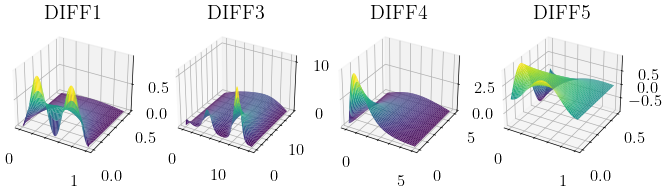

In [39]:
inds = [1, 3, 4, 5]
problems = [Diffusion.get_problem(i) for i in inds]
indexes = [141, 142, 143, 144]

size = (6.7, 1.8)
fig = plt.figure(figsize=size)

for i, index, problem in zip(inds, indexes, problems):
    X, T = np.meshgrid(problem.x, problem.t)
    ax = fig.add_subplot(index, projection='3d')
    ax.plot_surface(X, T, problem.solution, cmap='viridis')
    ax.title.set_text(f'DIFF{i}')
plt.tight_layout()

plt.savefig('../images/diff_grid.png', dpi=250)
plt.show()